In [1]:
!python -V

Python 3.12.9


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("nyc-taxis")

2025/05/21 20:15:39 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxis' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/253543047550040700', creation_time=1747829739599, experiment_id='253543047550040700', last_update_time=1747829739599, lifecycle_stage='active', name='nyc-taxis', tags={}>

In [8]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.827368941909368

C:\Users\crab\AppData\Local\Temp\ipykernel_29672\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\crab\AppData\Local\Temp\ipykernel_29672\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


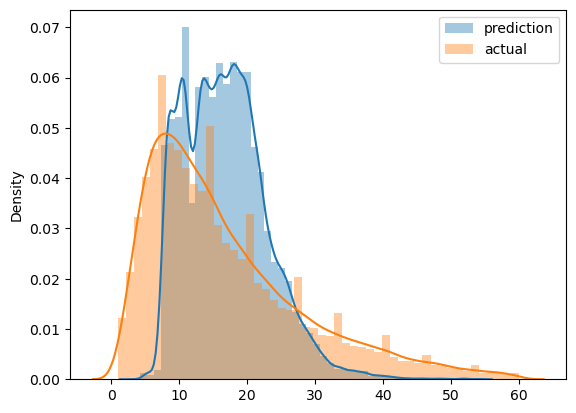

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715207460425

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


11.167275941179728

In [20]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "Jet")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val) 
    rsme = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rsme', rsme)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


🏃 View run aged-seal-323 at: http://127.0.0.1:5000/#/experiments/253543047550040700/runs/47b2f533b25746479b5366511081438c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/253543047550040700


In [21]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.78470                           
[1]	validation-rmse:6.69057                           
[2]	validation-rmse:6.67550                           
[3]	validation-rmse:6.66449                           
[4]	validation-rmse:6.65872                           
[5]	validation-rmse:6.65171                           
[6]	validation-rmse:6.64572                           
[7]	validation-rmse:6.63849                           
[8]	validation-rmse:6.63692                           
[9]	validation-rmse:6.63329                           
[10]	validation-rmse:6.63433                          
[11]	validation-rmse:6.63150                          
[12]	validation-rmse:6.62543                          
[13]	validation-rmse:6.61752                          
[14]	validation-rmse:6.61608                          
[15]	validation-rmse:6.61894                          
[16]	validation-rmse:6.61873                          
[17]	validation-rmse:6.61785                          
[18]	valid

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:25:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.59127                                                 
[1]	validation-rmse:11.03163                                                 
[2]	validation-rmse:10.53023                                                 
[3]	validation-rmse:10.08258                                                 
[4]	validation-rmse:9.68316                                                  
[5]	validation-rmse:9.32814                                                  
[6]	validation-rmse:9.01281                                                  
[7]	validation-rmse:8.73412                                                  
[8]	validation-rmse:8.48715                                                  
[9]	validation-rmse:8.26938                                                  
[10]	validation-rmse:8.07591                                                 
[11]	validation-rmse:7.90751                                                 
[12]	validation-rmse:7.75777                                    

[105]	validation-rmse:6.60844                                                
[106]	validation-rmse:6.60822                                                
[107]	validation-rmse:6.60747                                                
[108]	validation-rmse:6.60702                                                
[109]	validation-rmse:6.60634                                                
[110]	validation-rmse:6.60585                                                
[111]	validation-rmse:6.60516                                                
[112]	validation-rmse:6.60447                                                
[113]	validation-rmse:6.60373                                                
[114]	validation-rmse:6.60315                                                
[115]	validation-rmse:6.60280                                                
[116]	validation-rmse:6.60233                                                
[117]	validation-rmse:6.60177                                   

[210]	validation-rmse:6.56263                                                
[211]	validation-rmse:6.56249                                                
[212]	validation-rmse:6.56228                                                
[213]	validation-rmse:6.56185                                                
[214]	validation-rmse:6.56161                                                
[215]	validation-rmse:6.56133                                                
[216]	validation-rmse:6.56080                                                
[217]	validation-rmse:6.56067                                                
[218]	validation-rmse:6.56039                                                
[219]	validation-rmse:6.56006                                                
[220]	validation-rmse:6.55970                                                
[221]	validation-rmse:6.55923                                                
[222]	validation-rmse:6.55884                                   

[315]	validation-rmse:6.53153                                                
[316]	validation-rmse:6.53122                                                
[317]	validation-rmse:6.53075                                                
[318]	validation-rmse:6.53054                                                
[319]	validation-rmse:6.53036                                                
[320]	validation-rmse:6.53002                                                
[321]	validation-rmse:6.52992                                                
[322]	validation-rmse:6.52969                                                
[323]	validation-rmse:6.52950                                                
[324]	validation-rmse:6.52910                                                
[325]	validation-rmse:6.52902                                                
[326]	validation-rmse:6.52886                                                
[327]	validation-rmse:6.52857                                   

[420]	validation-rmse:6.50695                                                
[421]	validation-rmse:6.50673                                                
[422]	validation-rmse:6.50659                                                
[423]	validation-rmse:6.50653                                                
[424]	validation-rmse:6.50643                                                
[425]	validation-rmse:6.50634                                                
[426]	validation-rmse:6.50616                                                
[427]	validation-rmse:6.50592                                                
[428]	validation-rmse:6.50544                                                
[429]	validation-rmse:6.50527                                                
[430]	validation-rmse:6.50514                                                
[431]	validation-rmse:6.50494                                                
[432]	validation-rmse:6.50487                                   

[525]	validation-rmse:6.48659                                                
[526]	validation-rmse:6.48626                                                
[527]	validation-rmse:6.48615                                                
[528]	validation-rmse:6.48604                                                
[529]	validation-rmse:6.48584                                                
[530]	validation-rmse:6.48555                                                
[531]	validation-rmse:6.48530                                                
[532]	validation-rmse:6.48526                                                
[533]	validation-rmse:6.48512                                                
[534]	validation-rmse:6.48502                                                
[535]	validation-rmse:6.48504                                                
[536]	validation-rmse:6.48473                                                
[537]	validation-rmse:6.48448                                   

[630]	validation-rmse:6.46807                                                
[631]	validation-rmse:6.46785                                                
[632]	validation-rmse:6.46760                                                
[633]	validation-rmse:6.46745                                                
[634]	validation-rmse:6.46734                                                
[635]	validation-rmse:6.46715                                                
[636]	validation-rmse:6.46705                                                
[637]	validation-rmse:6.46692                                                
[638]	validation-rmse:6.46678                                                
[639]	validation-rmse:6.46660                                                
[640]	validation-rmse:6.46638                                                
[641]	validation-rmse:6.46622                                                
[642]	validation-rmse:6.46586                                   

[735]	validation-rmse:6.45323                                                
[736]	validation-rmse:6.45295                                                
[737]	validation-rmse:6.45277                                                
[738]	validation-rmse:6.45235                                                
[739]	validation-rmse:6.45221                                                
[740]	validation-rmse:6.45216                                                
[741]	validation-rmse:6.45189                                                
[742]	validation-rmse:6.45171                                                
[743]	validation-rmse:6.45161                                                
[744]	validation-rmse:6.45153                                                
[745]	validation-rmse:6.45145                                                
[746]	validation-rmse:6.45115                                                
[747]	validation-rmse:6.45111                                   

[840]	validation-rmse:6.43875                                                
[841]	validation-rmse:6.43865                                                
[842]	validation-rmse:6.43857                                                
[843]	validation-rmse:6.43840                                                
[844]	validation-rmse:6.43841                                                
[845]	validation-rmse:6.43828                                                
[846]	validation-rmse:6.43834                                                
[847]	validation-rmse:6.43820                                                
[848]	validation-rmse:6.43810                                                
[849]	validation-rmse:6.43798                                                
[850]	validation-rmse:6.43785                                                
[851]	validation-rmse:6.43759                                                
[852]	validation-rmse:6.43746                                   

[945]	validation-rmse:6.42732                                                
[946]	validation-rmse:6.42720                                                
[947]	validation-rmse:6.42717                                                
[948]	validation-rmse:6.42700                                                
[949]	validation-rmse:6.42700                                                
[950]	validation-rmse:6.42671                                                
[951]	validation-rmse:6.42661                                                
[952]	validation-rmse:6.42633                                                
[953]	validation-rmse:6.42632                                                
[954]	validation-rmse:6.42621                                                
[955]	validation-rmse:6.42599                                                
[956]	validation-rmse:6.42568                                                
[957]	validation-rmse:6.42556                                   

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.74429                                                    
[1]	validation-rmse:6.61987                                                    
[2]	validation-rmse:6.60169                                                    
[3]	validation-rmse:6.58329                                                    
[4]	validation-rmse:6.57093                                                    
[5]	validation-rmse:6.55948                                                    
[6]	validation-rmse:6.55021                                                    
[7]	validation-rmse:6.54601                                                    
[8]	validation-rmse:6.53860                                                    
[9]	validation-rmse:6.52550                                                    
[10]	validation-rmse:6.52134                                                   
[11]	validation-rmse:6.51617                                                   
[12]	validation-rmse:6.51492            

[102]	validation-rmse:6.45307                                                  
[103]	validation-rmse:6.45276                                                  
[104]	validation-rmse:6.45313                                                  
[105]	validation-rmse:6.45272                                                  
[106]	validation-rmse:6.45330                                                  
[107]	validation-rmse:6.45292                                                  
[108]	validation-rmse:6.45355                                                  
[109]	validation-rmse:6.45169                                                  
[110]	validation-rmse:6.45207                                                  
[111]	validation-rmse:6.45219                                                  
[112]	validation-rmse:6.45176                                                  
[113]	validation-rmse:6.45198                                                  
[114]	validation-rmse:6.45191           

[204]	validation-rmse:6.44696                                                  
[205]	validation-rmse:6.44598                                                  
[206]	validation-rmse:6.44617                                                  
[207]	validation-rmse:6.44629                                                  
[208]	validation-rmse:6.44679                                                  
[209]	validation-rmse:6.44642                                                  
[210]	validation-rmse:6.44675                                                  
[211]	validation-rmse:6.44605                                                  
[212]	validation-rmse:6.44613                                                  
[213]	validation-rmse:6.44670                                                  
[214]	validation-rmse:6.44652                                                  
[215]	validation-rmse:6.44706                                                  
[216]	validation-rmse:6.44773           

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:26:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.76459                                                   
[1]	validation-rmse:11.34924                                                   
[2]	validation-rmse:10.96510                                                   
[3]	validation-rmse:10.60914                                                   
[4]	validation-rmse:10.27930                                                   
[5]	validation-rmse:9.97216                                                    
[6]	validation-rmse:9.69170                                                    
[7]	validation-rmse:9.43388                                                    
[8]	validation-rmse:9.19731                                                    
[9]	validation-rmse:8.97974                                                    
[10]	validation-rmse:8.77985                                                   
[11]	validation-rmse:8.59532                                                   
[12]	validation-rmse:8.42777            

[102]	validation-rmse:6.50808                                                  
[103]	validation-rmse:6.50776                                                  
[104]	validation-rmse:6.50694                                                  
[105]	validation-rmse:6.50654                                                  
[106]	validation-rmse:6.50615                                                  
[107]	validation-rmse:6.50611                                                  
[108]	validation-rmse:6.50560                                                  
[109]	validation-rmse:6.50500                                                  
[110]	validation-rmse:6.50428                                                  
[111]	validation-rmse:6.50392                                                  
[112]	validation-rmse:6.50341                                                  
[113]	validation-rmse:6.50282                                                  
[114]	validation-rmse:6.50249           

[204]	validation-rmse:6.47246                                                  
[205]	validation-rmse:6.47221                                                  
[206]	validation-rmse:6.47194                                                  
[207]	validation-rmse:6.47166                                                  
[208]	validation-rmse:6.47123                                                  
[209]	validation-rmse:6.47104                                                  
[210]	validation-rmse:6.47086                                                  
[211]	validation-rmse:6.47062                                                  
[212]	validation-rmse:6.47015                                                  
[213]	validation-rmse:6.46988                                                  
[214]	validation-rmse:6.46973                                                  
[215]	validation-rmse:6.46965                                                  
[216]	validation-rmse:6.46961           

[306]	validation-rmse:6.45422                                                  
[307]	validation-rmse:6.45414                                                  
[308]	validation-rmse:6.45403                                                  
[309]	validation-rmse:6.45401                                                  
[310]	validation-rmse:6.45409                                                  
[311]	validation-rmse:6.45385                                                  
[312]	validation-rmse:6.45354                                                  
[313]	validation-rmse:6.45331                                                  
[314]	validation-rmse:6.45310                                                  
[315]	validation-rmse:6.45302                                                  
[316]	validation-rmse:6.45289                                                  
[317]	validation-rmse:6.45267                                                  
[318]	validation-rmse:6.45236           

[408]	validation-rmse:6.44081                                                  
[409]	validation-rmse:6.44068                                                  
[410]	validation-rmse:6.44048                                                  
[411]	validation-rmse:6.44039                                                  
[412]	validation-rmse:6.44028                                                  
[413]	validation-rmse:6.44020                                                  
[414]	validation-rmse:6.44009                                                  
[415]	validation-rmse:6.44002                                                  
[416]	validation-rmse:6.43995                                                  
[417]	validation-rmse:6.43976                                                  
[418]	validation-rmse:6.43968                                                  
[419]	validation-rmse:6.43962                                                  
[420]	validation-rmse:6.43965           

[510]	validation-rmse:6.43278                                                  
[511]	validation-rmse:6.43256                                                  
[512]	validation-rmse:6.43238                                                  
[513]	validation-rmse:6.43226                                                  
[514]	validation-rmse:6.43232                                                  
[515]	validation-rmse:6.43224                                                  
[516]	validation-rmse:6.43233                                                  
[517]	validation-rmse:6.43216                                                  
[518]	validation-rmse:6.43221                                                  
[519]	validation-rmse:6.43208                                                  
[520]	validation-rmse:6.43200                                                  
[521]	validation-rmse:6.43193                                                  
[522]	validation-rmse:6.43178           

[612]	validation-rmse:6.42618                                                  
[613]	validation-rmse:6.42608                                                  
[614]	validation-rmse:6.42602                                                  
[615]	validation-rmse:6.42596                                                  
[616]	validation-rmse:6.42584                                                  
[617]	validation-rmse:6.42586                                                  
[618]	validation-rmse:6.42582                                                  
[619]	validation-rmse:6.42588                                                  
[620]	validation-rmse:6.42586                                                  
[621]	validation-rmse:6.42596                                                  
[622]	validation-rmse:6.42601                                                  
[623]	validation-rmse:6.42580                                                  
[624]	validation-rmse:6.42585           

[714]	validation-rmse:6.42273                                                  
[715]	validation-rmse:6.42264                                                  
[716]	validation-rmse:6.42266                                                  
[717]	validation-rmse:6.42266                                                  
[718]	validation-rmse:6.42259                                                  
[719]	validation-rmse:6.42254                                                  
[720]	validation-rmse:6.42255                                                  
[721]	validation-rmse:6.42256                                                  
[722]	validation-rmse:6.42250                                                  
[723]	validation-rmse:6.42272                                                  
[724]	validation-rmse:6.42228                                                  
[725]	validation-rmse:6.42224                                                  
[726]	validation-rmse:6.42207           

[816]	validation-rmse:6.42058                                                  
[817]	validation-rmse:6.42053                                                  
[818]	validation-rmse:6.42053                                                  
[819]	validation-rmse:6.42052                                                  
[820]	validation-rmse:6.42046                                                  
[821]	validation-rmse:6.42050                                                  
[822]	validation-rmse:6.42045                                                  
[823]	validation-rmse:6.42046                                                  
[824]	validation-rmse:6.42039                                                  
[825]	validation-rmse:6.42027                                                  
[826]	validation-rmse:6.42024                                                  
[827]	validation-rmse:6.42021                                                  
[828]	validation-rmse:6.42023           

[918]	validation-rmse:6.41900                                                  
[919]	validation-rmse:6.41896                                                  
[920]	validation-rmse:6.41914                                                  
[921]	validation-rmse:6.41912                                                  
[922]	validation-rmse:6.41921                                                  
[923]	validation-rmse:6.41929                                                  
[924]	validation-rmse:6.41920                                                  
[925]	validation-rmse:6.41926                                                  
[926]	validation-rmse:6.41932                                                  
[927]	validation-rmse:6.41931                                                  
[928]	validation-rmse:6.41929                                                  
[929]	validation-rmse:6.41921                                                  
[930]	validation-rmse:6.41916           

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.11012                                                      
[1]	validation-rmse:8.75726                                                       
[2]	validation-rmse:7.91152                                                       
[3]	validation-rmse:7.39799                                                       
[4]	validation-rmse:7.08835                                                       
[5]	validation-rmse:6.90177                                                       
[6]	validation-rmse:6.78499                                                       
[7]	validation-rmse:6.71459                                                       
[8]	validation-rmse:6.66779                                                       
[9]	validation-rmse:6.63414                                                       
[10]	validation-rmse:6.61191                                                      
[11]	validation-rmse:6.59486                                                      
[12]

[98]	validation-rmse:6.45609                                                      
[99]	validation-rmse:6.45556                                                      
[100]	validation-rmse:6.45491                                                     
[101]	validation-rmse:6.45445                                                     
[102]	validation-rmse:6.45409                                                     
[103]	validation-rmse:6.45364                                                     
[104]	validation-rmse:6.45290                                                     
[105]	validation-rmse:6.45215                                                     
[106]	validation-rmse:6.45136                                                     
[107]	validation-rmse:6.45109                                                     
[108]	validation-rmse:6.45031                                                     
[109]	validation-rmse:6.44982                                                     
[110

[196]	validation-rmse:6.42194                                                     
[197]	validation-rmse:6.42148                                                     
[198]	validation-rmse:6.42120                                                     
[199]	validation-rmse:6.42114                                                     
[200]	validation-rmse:6.42085                                                     
[201]	validation-rmse:6.42035                                                     
[202]	validation-rmse:6.42029                                                     
[203]	validation-rmse:6.42008                                                     
[204]	validation-rmse:6.41923                                                     
[205]	validation-rmse:6.41845                                                     
[206]	validation-rmse:6.41836                                                     
[207]	validation-rmse:6.41806                                                     
[208

[294]	validation-rmse:6.40459                                                     
[295]	validation-rmse:6.40439                                                     
[296]	validation-rmse:6.40336                                                     
[297]	validation-rmse:6.40308                                                     
[298]	validation-rmse:6.40280                                                     
[299]	validation-rmse:6.40281                                                     
[300]	validation-rmse:6.40278                                                     
[301]	validation-rmse:6.40278                                                     
[302]	validation-rmse:6.40259                                                     
[303]	validation-rmse:6.40228                                                     
[304]	validation-rmse:6.40209                                                     
[305]	validation-rmse:6.40215                                                     
[306

[392]	validation-rmse:6.39735                                                     
[393]	validation-rmse:6.39719                                                     
[394]	validation-rmse:6.39727                                                     
[395]	validation-rmse:6.39716                                                     
[396]	validation-rmse:6.39719                                                     
[397]	validation-rmse:6.39708                                                     
[398]	validation-rmse:6.39708                                                     
[399]	validation-rmse:6.39698                                                     
[400]	validation-rmse:6.39694                                                     
[401]	validation-rmse:6.39706                                                     
[402]	validation-rmse:6.39679                                                     
[403]	validation-rmse:6.39683                                                     
[404

[490]	validation-rmse:6.39079                                                     
[491]	validation-rmse:6.39082                                                     
[492]	validation-rmse:6.39091                                                     
[493]	validation-rmse:6.39096                                                     
[494]	validation-rmse:6.39084                                                     
[495]	validation-rmse:6.39079                                                     
[496]	validation-rmse:6.39079                                                     
[497]	validation-rmse:6.39091                                                     
[498]	validation-rmse:6.39080                                                     
[499]	validation-rmse:6.39061                                                     
[500]	validation-rmse:6.39100                                                     
[501]	validation-rmse:6.39073                                                     
[502

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.50509                                                      
[1]	validation-rmse:9.29283                                                       
[2]	validation-rmse:8.44860                                                       
[3]	validation-rmse:7.87584                                                       
[4]	validation-rmse:7.48903                                                       
[5]	validation-rmse:7.22689                                                       
[6]	validation-rmse:7.05182                                                       
[7]	validation-rmse:6.93252                                                       
[8]	validation-rmse:6.84913                                                       
[9]	validation-rmse:6.79018                                                       
[10]	validation-rmse:6.75062                                                      
[11]	validation-rmse:6.72309                                                      
[12]

[98]	validation-rmse:6.55976                                                      
[99]	validation-rmse:6.55862                                                      
[100]	validation-rmse:6.55816                                                     
[101]	validation-rmse:6.55775                                                     
[102]	validation-rmse:6.55730                                                     
[103]	validation-rmse:6.55618                                                     
[104]	validation-rmse:6.55502                                                     
[105]	validation-rmse:6.55381                                                     
[106]	validation-rmse:6.55361                                                     
[107]	validation-rmse:6.55272                                                     
[108]	validation-rmse:6.55186                                                     
[109]	validation-rmse:6.55102                                                     
[110

[196]	validation-rmse:6.50710                                                     
[197]	validation-rmse:6.50670                                                     
[198]	validation-rmse:6.50597                                                     
[199]	validation-rmse:6.50549                                                     
[200]	validation-rmse:6.50523                                                     
[201]	validation-rmse:6.50450                                                     
[202]	validation-rmse:6.50477                                                     
[203]	validation-rmse:6.50446                                                     
[204]	validation-rmse:6.50543                                                     
[205]	validation-rmse:6.50474                                                     
[206]	validation-rmse:6.50408                                                     
[207]	validation-rmse:6.50420                                                     
[208

[294]	validation-rmse:6.47531                                                     
[295]	validation-rmse:6.47511                                                     
[296]	validation-rmse:6.47515                                                     
[297]	validation-rmse:6.47509                                                     
[298]	validation-rmse:6.47537                                                     
[299]	validation-rmse:6.47485                                                     
[300]	validation-rmse:6.47463                                                     
[301]	validation-rmse:6.47412                                                     
[302]	validation-rmse:6.47409                                                     
[303]	validation-rmse:6.47366                                                     
[304]	validation-rmse:6.47325                                                     
[305]	validation-rmse:6.47335                                                     
[306

[392]	validation-rmse:6.45752                                                     
[393]	validation-rmse:6.45744                                                     
[394]	validation-rmse:6.45757                                                     
[395]	validation-rmse:6.45780                                                     
[396]	validation-rmse:6.45773                                                     
[397]	validation-rmse:6.45748                                                     
[398]	validation-rmse:6.45642                                                     
[399]	validation-rmse:6.45636                                                     
[400]	validation-rmse:6.45627                                                     
[401]	validation-rmse:6.45630                                                     
[402]	validation-rmse:6.45603                                                     
[403]	validation-rmse:6.45588                                                     
[404

[490]	validation-rmse:6.44070                                                     
[491]	validation-rmse:6.44018                                                     
[492]	validation-rmse:6.44019                                                     
[493]	validation-rmse:6.44018                                                     
[494]	validation-rmse:6.43996                                                     
[495]	validation-rmse:6.43989                                                     
[496]	validation-rmse:6.43946                                                     
[497]	validation-rmse:6.44041                                                     
[498]	validation-rmse:6.44047                                                     
[499]	validation-rmse:6.44057                                                     
[500]	validation-rmse:6.44060                                                     
[501]	validation-rmse:6.44040                                                     
[502

[588]	validation-rmse:6.43076                                                     
[589]	validation-rmse:6.43074                                                     
[590]	validation-rmse:6.43036                                                     
[591]	validation-rmse:6.43099                                                     
[592]	validation-rmse:6.43095                                                     
[593]	validation-rmse:6.43040                                                     
[594]	validation-rmse:6.42978                                                     
[595]	validation-rmse:6.42985                                                     
[596]	validation-rmse:6.42952                                                     
[597]	validation-rmse:6.42923                                                     
[598]	validation-rmse:6.42859                                                     
[599]	validation-rmse:6.42872                                                     
[600

[686]	validation-rmse:6.42207                                                     
[687]	validation-rmse:6.42155                                                     
[688]	validation-rmse:6.42141                                                     
[689]	validation-rmse:6.42139                                                     
[690]	validation-rmse:6.42126                                                     
[691]	validation-rmse:6.42125                                                     
[692]	validation-rmse:6.42110                                                     
[693]	validation-rmse:6.42112                                                     
[694]	validation-rmse:6.42112                                                     
[695]	validation-rmse:6.42095                                                     
[696]	validation-rmse:6.42078                                                     
[697]	validation-rmse:6.42079                                                     
[698

[784]	validation-rmse:6.41094                                                     
[785]	validation-rmse:6.41088                                                     
[786]	validation-rmse:6.41114                                                     
[787]	validation-rmse:6.41105                                                     
[788]	validation-rmse:6.41079                                                     
[789]	validation-rmse:6.41093                                                     
[790]	validation-rmse:6.41065                                                     
[791]	validation-rmse:6.41068                                                     
[792]	validation-rmse:6.41055                                                     
[793]	validation-rmse:6.41059                                                     
[794]	validation-rmse:6.41041                                                     
[795]	validation-rmse:6.41036                                                     
[796

[882]	validation-rmse:6.40611                                                     
[883]	validation-rmse:6.40609                                                     
[884]	validation-rmse:6.40631                                                     
[885]	validation-rmse:6.40650                                                     
[886]	validation-rmse:6.40628                                                     
[887]	validation-rmse:6.40582                                                     
[888]	validation-rmse:6.40575                                                     
[889]	validation-rmse:6.40586                                                     
[890]	validation-rmse:6.40584                                                     
[891]	validation-rmse:6.40563                                                     
[892]	validation-rmse:6.40521                                                     
[893]	validation-rmse:6.40511                                                     
[894

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.59383                                                   
[1]	validation-rmse:11.03791                                                   
[2]	validation-rmse:10.53966                                                   
[3]	validation-rmse:10.09257                                                   
[4]	validation-rmse:9.69131                                                    
[5]	validation-rmse:9.33311                                                    
[6]	validation-rmse:9.01879                                                    
[7]	validation-rmse:8.73609                                                    
[8]	validation-rmse:8.48427                                                    
[9]	validation-rmse:8.26524                                                    
[10]	validation-rmse:8.06934                                                   
[11]	validation-rmse:7.89178                                                   
[12]	validation-rmse:7.73731            

[102]	validation-rmse:6.49614                                                  
[103]	validation-rmse:6.49568                                                  
[104]	validation-rmse:6.49504                                                  
[105]	validation-rmse:6.49478                                                  
[106]	validation-rmse:6.49447                                                  
[107]	validation-rmse:6.49398                                                  
[108]	validation-rmse:6.49364                                                  
[109]	validation-rmse:6.49327                                                  
[110]	validation-rmse:6.49285                                                  
[111]	validation-rmse:6.49216                                                  
[112]	validation-rmse:6.49174                                                  
[113]	validation-rmse:6.49123                                                  
[114]	validation-rmse:6.49035           

[204]	validation-rmse:6.45866                                                  
[205]	validation-rmse:6.45844                                                  
[206]	validation-rmse:6.45831                                                  
[207]	validation-rmse:6.45803                                                  
[208]	validation-rmse:6.45795                                                  
[209]	validation-rmse:6.45768                                                  
[210]	validation-rmse:6.45743                                                  
[211]	validation-rmse:6.45715                                                  
[212]	validation-rmse:6.45715                                                  
[213]	validation-rmse:6.45671                                                  
[214]	validation-rmse:6.45655                                                  
[215]	validation-rmse:6.45637                                                  
[216]	validation-rmse:6.45613           

[306]	validation-rmse:6.43814                                                  
[307]	validation-rmse:6.43803                                                  
[308]	validation-rmse:6.43781                                                  
[309]	validation-rmse:6.43744                                                  
[310]	validation-rmse:6.43735                                                  
[311]	validation-rmse:6.43724                                                  
[312]	validation-rmse:6.43708                                                  
[313]	validation-rmse:6.43689                                                  
[314]	validation-rmse:6.43653                                                  
[315]	validation-rmse:6.43634                                                  
[316]	validation-rmse:6.43621                                                  
[317]	validation-rmse:6.43547                                                  
[318]	validation-rmse:6.43532           

[408]	validation-rmse:6.42493                                                  
[409]	validation-rmse:6.42528                                                  
[410]	validation-rmse:6.42520                                                  
[411]	validation-rmse:6.42504                                                  
[412]	validation-rmse:6.42480                                                  
[413]	validation-rmse:6.42453                                                  
[414]	validation-rmse:6.42443                                                  
[415]	validation-rmse:6.42415                                                  
[416]	validation-rmse:6.42396                                                  
[417]	validation-rmse:6.42384                                                  
[418]	validation-rmse:6.42365                                                  
[419]	validation-rmse:6.42367                                                  
[420]	validation-rmse:6.42319           

[510]	validation-rmse:6.41387                                                  
[511]	validation-rmse:6.41376                                                  
[512]	validation-rmse:6.41357                                                  
[513]	validation-rmse:6.41350                                                  
[514]	validation-rmse:6.41375                                                  
[515]	validation-rmse:6.41382                                                  
[516]	validation-rmse:6.41360                                                  
[517]	validation-rmse:6.41356                                                  
[518]	validation-rmse:6.41341                                                  
[519]	validation-rmse:6.41341                                                  
[520]	validation-rmse:6.41348                                                  
[521]	validation-rmse:6.41340                                                  
[522]	validation-rmse:6.41329           

[612]	validation-rmse:6.40754                                                  
[613]	validation-rmse:6.40746                                                  
[614]	validation-rmse:6.40750                                                  
[615]	validation-rmse:6.40746                                                  
[616]	validation-rmse:6.40727                                                  
[617]	validation-rmse:6.40725                                                  
[618]	validation-rmse:6.40738                                                  
[619]	validation-rmse:6.40719                                                  
[620]	validation-rmse:6.40714                                                  
[621]	validation-rmse:6.40703                                                  
[622]	validation-rmse:6.40698                                                  
[623]	validation-rmse:6.40681                                                  
[624]	validation-rmse:6.40693           

[714]	validation-rmse:6.40340                                                  
[715]	validation-rmse:6.40343                                                  
[716]	validation-rmse:6.40337                                                  
[717]	validation-rmse:6.40327                                                  
[718]	validation-rmse:6.40332                                                  
[719]	validation-rmse:6.40315                                                  
[720]	validation-rmse:6.40311                                                  
[721]	validation-rmse:6.40301                                                  
[722]	validation-rmse:6.40279                                                  
[723]	validation-rmse:6.40291                                                  
[724]	validation-rmse:6.40288                                                  
[725]	validation-rmse:6.40278                                                  
[726]	validation-rmse:6.40277           

[816]	validation-rmse:6.40137                                                  
[817]	validation-rmse:6.40144                                                  
[818]	validation-rmse:6.40140                                                  
[819]	validation-rmse:6.40145                                                  
[820]	validation-rmse:6.40142                                                  
[821]	validation-rmse:6.40137                                                  
[822]	validation-rmse:6.40134                                                  
[823]	validation-rmse:6.40127                                                  
[824]	validation-rmse:6.40124                                                  
[825]	validation-rmse:6.40108                                                  
[826]	validation-rmse:6.40104                                                  
[827]	validation-rmse:6.40094                                                  
[828]	validation-rmse:6.40090           

[918]	validation-rmse:6.40067                                                  
[919]	validation-rmse:6.40065                                                  
[920]	validation-rmse:6.40085                                                  
[921]	validation-rmse:6.40078                                                  
[922]	validation-rmse:6.40088                                                  
[923]	validation-rmse:6.40089                                                  
[924]	validation-rmse:6.40085                                                  
[925]	validation-rmse:6.40085                                                  
[926]	validation-rmse:6.40092                                                  
[927]	validation-rmse:6.40095                                                  
[928]	validation-rmse:6.40099                                                  
[929]	validation-rmse:6.40092                                                  
[930]	validation-rmse:6.40099           

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:35:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.59785                                                       
[1]	validation-rmse:8.15747                                                       
[2]	validation-rmse:7.40399                                                       
[3]	validation-rmse:7.02055                                                       
[4]	validation-rmse:6.82193                                                       
[5]	validation-rmse:6.71500                                                       
[6]	validation-rmse:6.64971                                                       
[7]	validation-rmse:6.61178                                                       
[8]	validation-rmse:6.58350                                                       
[9]	validation-rmse:6.56604                                                       
[10]	validation-rmse:6.55396                                                      
[11]	validation-rmse:6.54183                                                      
[12]

[98]	validation-rmse:6.45859                                                      
[99]	validation-rmse:6.45830                                                      
[100]	validation-rmse:6.45825                                                     
[101]	validation-rmse:6.45826                                                     
[102]	validation-rmse:6.45769                                                     
[103]	validation-rmse:6.45785                                                     
[104]	validation-rmse:6.45789                                                     
[105]	validation-rmse:6.45750                                                     
[106]	validation-rmse:6.45709                                                     
[107]	validation-rmse:6.45735                                                     
[108]	validation-rmse:6.45769                                                     
[109]	validation-rmse:6.45732                                                     
[110

[196]	validation-rmse:6.45184                                                     
[197]	validation-rmse:6.45195                                                     
[198]	validation-rmse:6.45261                                                     
[199]	validation-rmse:6.45188                                                     
[200]	validation-rmse:6.45195                                                     
[201]	validation-rmse:6.45253                                                     
[202]	validation-rmse:6.45264                                                     
[203]	validation-rmse:6.45221                                                     
[204]	validation-rmse:6.45222                                                     
[205]	validation-rmse:6.45214                                                     
[206]	validation-rmse:6.45215                                                     
[207]	validation-rmse:6.45221                                                     
[208

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:36:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.18509                                                     
[1]	validation-rmse:8.83064                                                      
[2]	validation-rmse:7.95194                                                      
[3]	validation-rmse:7.39600                                                      
[4]	validation-rmse:7.04807                                                      
[5]	validation-rmse:6.83336                                                      
[6]	validation-rmse:6.69539                                                      
[7]	validation-rmse:6.61142                                                      
[8]	validation-rmse:6.55331                                                      
[9]	validation-rmse:6.51337                                                      
[10]	validation-rmse:6.48291                                                     
[11]	validation-rmse:6.46291                                                     
[12]	validation-

[99]	validation-rmse:6.33990                                                     
[100]	validation-rmse:6.33943                                                    
[101]	validation-rmse:6.33916                                                    
[102]	validation-rmse:6.33881                                                    
[103]	validation-rmse:6.33864                                                    
[104]	validation-rmse:6.33785                                                    
[105]	validation-rmse:6.33849                                                    
[106]	validation-rmse:6.33844                                                    
[107]	validation-rmse:6.33853                                                    
[108]	validation-rmse:6.33794                                                    
[109]	validation-rmse:6.33709                                                    
[110]	validation-rmse:6.33730                                                    
[111]	validation

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.16178                                                      
[1]	validation-rmse:7.11274                                                      
[2]	validation-rmse:6.85487                                                      
[3]	validation-rmse:6.77191                                                      
[4]	validation-rmse:6.72675                                                      
[5]	validation-rmse:6.70084                                                      
[6]	validation-rmse:6.68757                                                      
[7]	validation-rmse:6.68293                                                      
[8]	validation-rmse:6.68165                                                      
[9]	validation-rmse:6.68092                                                      
[10]	validation-rmse:6.67891                                                     
[11]	validation-rmse:6.67845                                                     
[12]	validation-

[99]	validation-rmse:6.64961                                                     
[100]	validation-rmse:6.64929                                                    
[101]	validation-rmse:6.64972                                                    
[102]	validation-rmse:6.64926                                                    
[103]	validation-rmse:6.64920                                                    
[104]	validation-rmse:6.64927                                                    
[105]	validation-rmse:6.64872                                                    
[106]	validation-rmse:6.64912                                                    
[107]	validation-rmse:6.64834                                                    
[108]	validation-rmse:6.64864                                                    
[109]	validation-rmse:6.64845                                                    
[110]	validation-rmse:6.64846                                                    
[111]	validation

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.45203                                                     
[1]	validation-rmse:7.26620                                                     
[2]	validation-rmse:6.92189                                                     
[3]	validation-rmse:6.81064                                                     
[4]	validation-rmse:6.76217                                                     
 20%|██        | 10/50 [14:03<51:23, 77.09s/trial, best loss: 6.340271924118359]

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:6.74831                                                     
[6]	validation-rmse:6.73636                                                     
[7]	validation-rmse:6.73074                                                     
[8]	validation-rmse:6.72412                                                     
[9]	validation-rmse:6.71989                                                     
[10]	validation-rmse:6.71486                                                    
[11]	validation-rmse:6.71295                                                    
[12]	validation-rmse:6.70754                                                    
[13]	validation-rmse:6.70528                                                    
[14]	validation-rmse:6.70383                                                    
[15]	validation-rmse:6.70032                                                    
[16]	validation-rmse:6.69865                                                    
[17]	validation-rmse:6.69771

[106]	validation-rmse:6.54124                                                   
[107]	validation-rmse:6.54026                                                   
[108]	validation-rmse:6.53932                                                   
[109]	validation-rmse:6.53913                                                   
[110]	validation-rmse:6.53931                                                   
[111]	validation-rmse:6.53811                                                   
[112]	validation-rmse:6.53726                                                   
[113]	validation-rmse:6.53667                                                   
[114]	validation-rmse:6.53490                                                   
[115]	validation-rmse:6.53375                                                   
[116]	validation-rmse:6.53306                                                   
[117]	validation-rmse:6.53034                                                   
[118]	validation-rmse:6.5280

[207]	validation-rmse:6.46791                                                   
[208]	validation-rmse:6.46830                                                   
[209]	validation-rmse:6.46790                                                   
[210]	validation-rmse:6.46688                                                   
[211]	validation-rmse:6.46670                                                   
[212]	validation-rmse:6.46402                                                   
[213]	validation-rmse:6.46480                                                   
[214]	validation-rmse:6.46452                                                   
[215]	validation-rmse:6.46412                                                   
[216]	validation-rmse:6.46395                                                   
[217]	validation-rmse:6.46285                                                   
[218]	validation-rmse:6.46240                                                   
[219]	validation-rmse:6.4619

[308]	validation-rmse:6.41966                                                   
[309]	validation-rmse:6.41971                                                   
[310]	validation-rmse:6.42107                                                   
[311]	validation-rmse:6.41993                                                   
[312]	validation-rmse:6.41975                                                   
[313]	validation-rmse:6.41493                                                   
[314]	validation-rmse:6.41498                                                   
[315]	validation-rmse:6.41464                                                   
[316]	validation-rmse:6.41443                                                   
[317]	validation-rmse:6.41399                                                   
[318]	validation-rmse:6.41293                                                   
[319]	validation-rmse:6.41342                                                   
[320]	validation-rmse:6.4135

[409]	validation-rmse:6.38436                                                   
[410]	validation-rmse:6.38362                                                   
[411]	validation-rmse:6.38406                                                   
[412]	validation-rmse:6.38404                                                   
[413]	validation-rmse:6.38349                                                   
[414]	validation-rmse:6.38355                                                   
[415]	validation-rmse:6.38313                                                   
[416]	validation-rmse:6.38283                                                   
[417]	validation-rmse:6.38231                                                   
[418]	validation-rmse:6.38223                                                   
[419]	validation-rmse:6.38220                                                   
[420]	validation-rmse:6.38180                                                   
[421]	validation-rmse:6.3819

[510]	validation-rmse:6.35715                                                   
[511]	validation-rmse:6.35709                                                   
[512]	validation-rmse:6.35709                                                   
[513]	validation-rmse:6.35639                                                   
[514]	validation-rmse:6.35572                                                   
[515]	validation-rmse:6.35573                                                   
[516]	validation-rmse:6.35477                                                   
[517]	validation-rmse:6.35480                                                   
[518]	validation-rmse:6.35466                                                   
[519]	validation-rmse:6.35435                                                   
[520]	validation-rmse:6.35450                                                   
[521]	validation-rmse:6.35422                                                   
[522]	validation-rmse:6.3544

[611]	validation-rmse:6.33695                                                   
[612]	validation-rmse:6.33677                                                   
[613]	validation-rmse:6.33688                                                   
[614]	validation-rmse:6.33658                                                   
[615]	validation-rmse:6.33639                                                   
[616]	validation-rmse:6.33620                                                   
[617]	validation-rmse:6.33617                                                   
[618]	validation-rmse:6.33603                                                   
[619]	validation-rmse:6.33605                                                   
[620]	validation-rmse:6.33603                                                   
[621]	validation-rmse:6.33584                                                   
[622]	validation-rmse:6.33600                                                   
[623]	validation-rmse:6.3360

[712]	validation-rmse:6.32605                                                   
[713]	validation-rmse:6.32556                                                   
[714]	validation-rmse:6.32566                                                   
[715]	validation-rmse:6.32556                                                   
[716]	validation-rmse:6.32479                                                   
[717]	validation-rmse:6.32461                                                   
[718]	validation-rmse:6.32452                                                   
[719]	validation-rmse:6.32442                                                   
[720]	validation-rmse:6.32451                                                   
[721]	validation-rmse:6.32534                                                   
[722]	validation-rmse:6.32437                                                   
[723]	validation-rmse:6.32442                                                   
[724]	validation-rmse:6.3245

[813]	validation-rmse:6.31548                                                   
[814]	validation-rmse:6.31551                                                   
[815]	validation-rmse:6.31549                                                   
[816]	validation-rmse:6.31561                                                   
[817]	validation-rmse:6.31553                                                   
[818]	validation-rmse:6.31556                                                   
[819]	validation-rmse:6.31570                                                   
[820]	validation-rmse:6.31560                                                   
[821]	validation-rmse:6.31614                                                   
[822]	validation-rmse:6.31595                                                   
[823]	validation-rmse:6.31592                                                   
[824]	validation-rmse:6.31566                                                   
[825]	validation-rmse:6.3154

[914]	validation-rmse:6.31090                                                   
[915]	validation-rmse:6.31086                                                   
[916]	validation-rmse:6.31084                                                   
[917]	validation-rmse:6.31086                                                   
[918]	validation-rmse:6.31106                                                   
[919]	validation-rmse:6.31108                                                   
[920]	validation-rmse:6.31089                                                   
[921]	validation-rmse:6.31057                                                   
[922]	validation-rmse:6.31029                                                   
[923]	validation-rmse:6.31006                                                   
[924]	validation-rmse:6.31033                                                   
[925]	validation-rmse:6.31040                                                   
[926]	validation-rmse:6.3103

C:\Users\crab\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\crab\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:39:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44968                                                     
[1]	validation-rmse:10.77883                                                     
[2]	validation-rmse:10.18987                                                     
[3]	validation-rmse:9.67654                                                      
[4]	validation-rmse:9.22891                                                      
[5]	validation-rmse:8.84086                                                      
[6]	validation-rmse:8.50393                                                      
[7]	validation-rmse:8.21353                                                      
[8]	validation-rmse:7.96522                                                      
[9]	validation-rmse:7.75100                                                      
[10]	validation-rmse:7.56670                                                     
[11]	validation-rmse:7.41019                                                     
[12]	validation-

[99]	validation-rmse:6.38574                                                     
[100]	validation-rmse:6.38527                                                    
[101]	validation-rmse:6.38430                                                    
[102]	validation-rmse:6.38367                                                    
[103]	validation-rmse:6.38322                                                    
[104]	validation-rmse:6.38279                                                    
[105]	validation-rmse:6.38227                                                    
[106]	validation-rmse:6.38190                                                    
[107]	validation-rmse:6.38172                                                    
[108]	validation-rmse:6.38124                                                    
[109]	validation-rmse:6.38057                                                    
[110]	validation-rmse:6.38040                                                    
[111]	validation

In [25]:

params = {
    'learning_rate' : 0.14617073692396848, 
    'max_depth': 57,
    'min_child_weight': 1.0543003960973405,
    'objective': 'reg:linear',
    'reg_alpha': 0.05008428417954409,
    'reg_lambda': 0.010143480198486687,
    'seed': 42}

mlflow.xgboost.autolog(disable=True)

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2024/05/24 16:16:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7ce17c5f0956488ba140174fb92b772b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:16:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.03728
[1]	validation-rmse:10.08320
[2]	validation-rmse:9.31779
[3]	validation-rmse:8.70727
[4]	validation-rmse:8.22423
[5]	validation-rmse:7.84280
[6]	validation-rmse:7.54930
[7]	validation-rmse:7.32107
[8]	validation-rmse:7.14160
[9]	validation-rmse:7.00340
[10]	validation-rmse:6.89215
[11]	validation-rmse:6.80637
[12]	validation-rmse:6.74031
[13]	validation-rmse:6.68849
[14]	validation-rmse:6.64535
[15]	validation-rmse:6.61234
[16]	validation-rmse:6.58376
[17]	validation-rmse:6.56171
[18]	validation-rmse:6.54239
[19]	validation-rmse:6.52566
[20]	validation-rmse:6.51313
[21]	validation-rmse:6.50205
[22]	validation-rmse:6.49305
[23]	validation-rmse:6.48523
[24]	validation-rmse:6.47829
[25]	validation-rmse:6.47201
[26]	validation-rmse:6.46686
[27]	validation-rmse:6.46178
[28]	validation-rmse:6.45759
[29]	validation-rmse:6.45443
[30]	validation-rmse:6.45128
[31]	validation-rmse:6.44885
[32]	validation-rmse:6.44705
[33]	validation-rmse:6.44555
[34]	validation-rmse:6

2024/05/24 16:18:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:18:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/05/24 16:18:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the tradit

In [21]:
with mlflow.start_run():
    params = {
    'learning_rate' : 0.14617073692396848, 
    'max_depth': 57,
    'min_child_weight': 1.0543003960973405,
    'objective': 'reg:linear',
    'reg_alpha': 0.05008428417954409,
    'reg_lambda': 0.010143480198486687,
    'seed': 42}
    
    mlflow.log_params(params)

    
    mlflow.xgboost.autolog(disable=True)

    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)


    booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
            )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path = "preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [18:03:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.03728
[1]	validation-rmse:10.08320
[2]	validation-rmse:9.31779
[3]	validation-rmse:8.70727
[4]	validation-rmse:8.22423
[5]	validation-rmse:7.84280
[6]	validation-rmse:7.54930
[7]	validation-rmse:7.32107
[8]	validation-rmse:7.14160
[9]	validation-rmse:7.00340
[10]	validation-rmse:6.89215
[11]	validation-rmse:6.80637
[12]	validation-rmse:6.74031
[13]	validation-rmse:6.68849
[14]	validation-rmse:6.64535
[15]	validation-rmse:6.61234
[16]	validation-rmse:6.58376
[17]	validation-rmse:6.56171
[18]	validation-rmse:6.54239
[19]	validation-rmse:6.52566
[20]	validation-rmse:6.51313
[21]	validation-rmse:6.50205
[22]	validation-rmse:6.49305
[23]	validation-rmse:6.48523
[24]	validation-rmse:6.47829
[25]	validation-rmse:6.47201
[26]	validation-rmse:6.46686
[27]	validation-rmse:6.46178
[28]	validation-rmse:6.45759
[29]	validation-rmse:6.45443
[30]	validation-rmse:6.45128
[31]	validation-rmse:6.44885
[32]	validation-rmse:6.44705
[33]	validation-rmse:6.44555
[34]	validation-rmse:6

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [18:04:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [25]:
import mlflow
logged_model = 'runs:/a659b685bcb64c08be9d0af6fc9020ce/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
 

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [18:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [26]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: a659b685bcb64c08be9d0af6fc9020ce

In [27]:
xgboost_model = mlflow.xgboost.load_model(model_uri=logged_model)

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [18:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [28]:
xgboost_model

In [31]:
y_pred = xgboost_model.predict(valid)

In [32]:
y_pred [:10]

array([14.212163 ,  7.0482526, 14.264443 , 24.46753  ,  9.496451 ,
       17.1498   , 10.447105 ,  8.409666 ,  9.762197 , 17.557404 ],
      dtype=float32)

In [28]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog(log_datasets = False)

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The defau